# ML2025 Homework 6 - Fine-tuning leads to Forgetting

This notebook is for ML2025 Homework 6, focusing on the problem of fine-tuning leading to forgetting. The goal is to fine-tune a model using the GSM8K dataset while observing the effects on previously learned knowledge about safeness.

## Check GPU

In [2]:
!nvidia-smi

Thu May  8 07:08:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Download Dataset & Install Packages

In [3]:
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train.jsonl # original dataset for fine-tuning
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train_self-instruct.jsonl # part of fine-tuning dataset refined by llama-3.2-1b-instruct
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_test_public.jsonl # gsm8k public test dataset
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_test_private.jsonl # gsm8k private test dataset
!wget https://www.csie.ntu.edu.tw/~b10902031/ailuminate_test.csv # ailuminate test dataset (public + private)

--2025-05-08 07:09:01--  https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train.jsonl
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4166206 (4.0M)
Saving to: ‘gsm8k_train.jsonl’

gsm8k_train.jsonl   100%[===================>]   3.97M  3.98MB/s    in 1.0s    

2025-05-08 07:09:03 (3.98 MB/s) - ‘gsm8k_train.jsonl’ saved [4166206/4166206]

--2025-05-08 07:09:03--  https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train_self-instruct.jsonl
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4912246 (4.7M)
Saving to: ‘gsm8k_train_self-instruct.jsonl’

gsm8k_train_self-in 100%[===================>]   4.68M  2.42MB/s    in 1.9s    

2025-05-08 07:09:05 (2.42 MB/s) - ‘gsm8k_train_

In [4]:
!pip install -U datasets trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 21.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

## Huggingface Login

In [6]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

hf_token = UserSecretsClient().get_secret("HF_TOKEN")
login(token=hf_token)
# !huggingface-cli login --token hf_token # TODO: Add your huggingface token

## Import Packages

In [7]:
from transformers import (
    AutoModelForCausalLM, # imports the model for causal language modeling
    AutoTokenizer, # imports the tokenizer for the model
    BitsAndBytesConfig, # imports the configuration for using bitsandbytes
    pipeline # imports the pipeline for text generation
)
from peft import (
    LoraConfig, # imports the configuration for LoRA
    get_peft_model, # imports the function to get the PEFT model
    PeftModel # imports the PEFT model
)
import os
import json
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Sets the CUDA device to use
device = torch.device('cuda:0') # Creates a CUDA device object
from datasets import Dataset # Imports the Dataset class from the datasets library
from trl import SFTConfig, SFTTrainer # Imports the SFTConfig and SFTTrainer classes from the trl library
import random
random.seed(42) # Sets the random seed for reproducibility
from tqdm import tqdm # Imports the tqdm library for progress bars
import csv

2025-05-08 07:25:24.095431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746689124.279719      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746689124.335790      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## LLM Fine-tuning

### Load Model & Tokenizer

In [8]:
sft_model_name = 'meta-llama/Llama-3.2-1B-Instruct' # Specifies the name of the pre-trained model to use
sft_bnb_config = BitsAndBytesConfig( # Configuration for using bitsandbytes
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
sft_model = AutoModelForCausalLM.from_pretrained( # Loads the pre-trained model
    pretrained_model_name_or_path=sft_model_name,
    quantization_config=sft_bnb_config,
    low_cpu_mem_usage=True,
)
sft_tokenizer = AutoTokenizer.from_pretrained( # Loads the tokenizer for the model
    pretrained_model_name_or_path=sft_model_name,
)
sft_tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Adds a special token for padding
peft_config = LoraConfig(
    r=4,
    lora_alpha=16,
    # TODO: Adds dropout
    bias='none',
    task_type='CAUSAL_LM',
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
peft_model = get_peft_model(sft_model, peft_config)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

### Dataset Formatting Functions

In [12]:
def load_jsonlines(file_name: str):
    f = open(file_name, 'r')
    return [json.loads(line) for line in f]

def nshot_chats(nshot_data: list, n: int, question: str, answer: any, mode: str) -> dict: # Function to create n-shot chats
    if mode not in ['train', 'test']:
        raise AssertionError('Undefined Mode!!!')

    chats = []
    # TODO: Use fixed few-shot examples
    for qna in nshot_data[:n]: # Samples n examples from the n-shot data
        chats.append(
            {
                'role': 'user',
                'content': f'Q: {qna["question"]}' # Creates a user message with the question
            }
        )
        chats.append(
            {
                'role': 'assistant',
                'content': f'A: {qna["answer"]}' # Creates an assistant message with the answer
            }
        )

    chats.append(
        {
            'role': 'user',
            'content': f'Q: {question} Let\'s think step by step. At the end, you MUST write the answer as an integer after \'####\'.' # Creates a user message with the question and instructions
        }
    )
    if mode == 'train':
        chats.append(
            {
                'role': 'assistant',
                'content': f'A: {answer}' # Creates an assistant message with the answer
            }
        )

    return chats # Returns the list of chats

In [11]:
gsm8k_train = load_jsonlines('gsm8k_train_self-instruct.jsonl') # You can use refined gsm8k_train_self-instruct.jsonl for fine-tuning
print(gsm8k_train[:3])

[{'question': 'Yanna bought ten shirts at $5 each and three pairs of sandals at $3 each.  How much change did she get back if she gave a one hundred dollar bill?', 'answer': 'Yanna bought 10 shirts at $5 each, so 10 x $5 = $50\nShe also bought 3 pairs of sandals at $3 each, so 3 x $3 = $9\nThe total cost of the items is $50 + $9 = $59\nIf she pays with a $100 bill, the change she gets back is $100 - $59 = $41\n#### 41'}, {'question': 'Felicia is baking a cake. She needs 2 cups of flour, a cup of white sugar, a 1/4 cup of brown sugar, and a 1/2 cup of oil. Her only measuring scoop is 1/4 cup. How many times does she fill it to complete the measurements?', 'answer': "First, we need to convert the measurements to the same unit. We'll convert all measurements to cups. 2 cups of flour is equivalent to 2 cups. 1 cup of white sugar is equivalent to 1 cup. 1/4 cup of brown sugar is equivalent to 1/4 cup. 1/2 cup of oil is equivalent to 1/2 cup.\n\nNow, let's calculate how many times she needs 

### Format GSM8K Data for Fine-tuning

{'text': ["<|start_header_id|>user<|end_header_id|>\n\nQ: Yanna bought ten shirts at $5 each and three pairs of sandals at $3 each.  How much change did she get back if she gave a one hundred dollar bill?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nA: Yanna bought 10 shirts at $5 each, so 10 x $5 = $50\nShe also bought 3 pairs of sandals at $3 each, so 3 x $3 = $9\nThe total cost of the items is $50 + $9 = $59\nIf she pays with a $100 bill, the change she gets back is $100 - $59 = $41\n#### 41<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nQ: Felicia is baking a cake. She needs 2 cups of flour, a cup of white sugar, a 1/4 cup of brown sugar, and a 1/2 cup of oil. Her only measuring scoop is 1/4 cup. How many times does she fill it to complete the measurements?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nA: First, we need to convert the measurements to the same unit. We'll convert all measurements to cups. 2 cups of flour is equivalent to 2 cups. 1 cup 

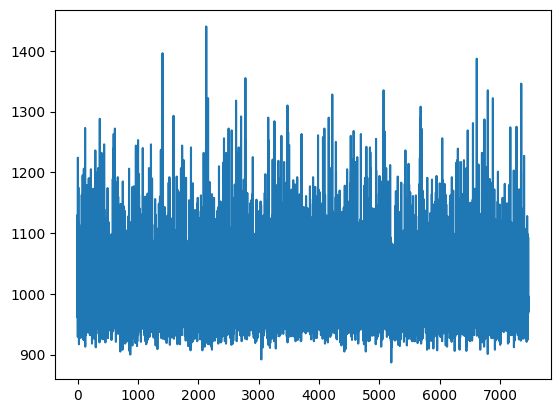

In [13]:
import matplotlib.pyplot as plt
import numpy as np

gsm8k_train = load_jsonlines('gsm8k_train_self-instruct.jsonl') # You can use refined gsm8k_train_self-instruct.jsonl for fine-tuning
# gsm8k_train = load_jsonlines('gsm8k_train.jsonl')
dataset_len = np.zeros(len(gsm8k_train))
i = 0

formatted_gsm8k = []
TRAIN_N_SHOT = 5 # TODO: Give model more examples: 5~8
max_token_len = 0 # Record token length of dataset and prevent data from truncation

for qna in gsm8k_train: # Iterates over the GSM8K training data
    chats = nshot_chats(nshot_data=gsm8k_train, n=TRAIN_N_SHOT, question=qna['question'], answer=qna['answer'], mode='train') # Creates n-shot chats for the current example
    train_sample = sft_tokenizer.apply_chat_template(chats, tokenize=False) # Applies the chat template to the chats
    train_sample = train_sample[train_sample.index("<|eot_id|>") + len("<|eot_id|>"):] # Remove Cutting Knowledge Date in prompt template
    formatted_gsm8k.append( # Appends the formatted example to the list
        {
            'text': train_sample # Adds the text of the example
        }
    )
    max_token_len = max(max_token_len, len(sft_tokenizer(train_sample)['input_ids'])) # Updates the maximum token length
    dataset_len[i] = len(sft_tokenizer(train_sample)['input_ids'])
    i = i+1

formatted_gsm8k = Dataset.from_list(formatted_gsm8k) # Creates a dataset from the list of formatted examples
plt.plot(dataset_len)
plt.show()

### Fine-tuning

In [ ]:
# trainer
# Add a learning rate scheduler with warm-up
from transformers import get_scheduler

training_arguments = SFTConfig( # Configuration for the SFT trainer
    seed=1126,
    data_seed=1126,
    output_dir=f"sft",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    num_train_epochs=3, # TODO: If you use fixed few-shot examples, increase epoch
    logging_strategy="steps",
    logging_steps=0.1/3,
    save_strategy="steps",
    save_steps=0.1/3,
    lr_scheduler_type='linear',
    learning_rate=4e-5, # TODO: Decrease learning rate: 1e-4~1e-5
    warmup_ratio=0.1,
    # TODO: Add weight decay
    bf16=True,
    group_by_length=True,
    max_seq_length=max_token_len,
    dataset_text_field='text',
    report_to='none',
    weight_decay=0.01,
)
trainer = SFTTrainer( # Creates the SFT trainer
    model=peft_model,
    train_dataset=formatted_gsm8k,
    peft_config=peft_config,
    processing_class=sft_tokenizer,
    args=training_arguments,
)
trainer.train() # Starts the training process